In [1]:
import pandas as pd
import numpy as np
import glob

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import LatentDirichletAllocation

import scipy.sparse
from scipy.sparse import csr_matrix, hstack

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('/home/ec2-user/anaconda3/envs/JupyterSystemEnv/lib/python3.6/site-packages')
from xgboost.sklearn import XGBClassifier

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Reading relevant files

In [2]:
ipb = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/ipblocks_fulldump_20190223.txt", sep ='\t')
#ipb = pd.read_csv("ipblocks_fulldump.csv")
ipb = ipb[['ipb_address','date']]
ipb.rename(columns = {'ipb_address':"username",'date':'bl_date'}, inplace=True)
ipb.bl_date = ipb.bl_date.astype('str')
ipb.bl_date = pd.to_datetime(ipb.bl_date)
ipb['ipb_bl'] = 1
print(len(ipb))
ipb.head()

1166572


,username,bl_date,ipb_bl
0,Wanli2,2004-02-08,1
1,Xuepiao,2004-02-08,1
2,GrandVoivodOfErdely,2004-02-08,1
3,#1703,2004-02-13,1
4,Wanli3,2004-03-14,1


In [3]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Blocked/*.csv')
d2=pd.DataFrame()
for file in files:
    d2s = pd.read_csv(file)
    d2 = pd.concat([d2,d2s])
print(d2.shape)
d2.dates = d2.dates.astype('str')
d2.dates = pd.to_datetime(d2.dates).dt.date
d2.dates = pd.to_datetime(d2.dates)
d2.drop(columns=['Unnamed: 0','links'], inplace=True)
d2.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d2['bl'] = 1
d2 = d2[~d2.char_changes.str.contains('-')]
print(d2.shape)
d2.tail()

(124102, 6)
(99761, 5)


,char_changes,revision_date,username,text,bl
32362,+420,2018-05-24,Quek157,:PROD = proposed deletion (anyone can challeng...,1
32363,+171,2018-05-24,Quek157,":::::::thanks, I think you will know who I am ...",1
32364,+924,2018-05-24,Quek157,"::::::{{reply to|Alexanderlee}}, no problems, ...",1
32365,+46,2018-05-24,Quek157,":::{{reply to|Snowflake91|Chrissymad}}Good, ac...",1
32366,+571,2018-05-24,Quek157,":::: I know, I am now exactly talking about so...",1


In [4]:
files = glob.glob('/home/ec2-user/SageMaker/bucket/wiki_trust/revisions_data/csvs_stored/Non_Blocked/*.csv')
d3=pd.DataFrame()
for file in files:
    d3s = pd.read_csv(file)
    d3 = pd.concat([d3,d3s])
print(d3.shape)
d3.dates = d3.dates.astype('str')
d3.dates = pd.to_datetime(d3.dates).dt.date
d3.dates = pd.to_datetime(d3.dates)
d3.drop(columns=['Unnamed: 0','links'], inplace=True)
d3.rename(columns={"user":"username","dates":"revision_date"},inplace=True)
d3['bl'] = 0
d3 = d3[~d3.char_changes.str.contains('-')]
print(d3.shape)
d3.tail()

(257082, 6)
(219751, 5)


,char_changes,revision_date,username,text,bl
41479,0,2018-08-07,Tebus19,NaN,0
41480,0,2018-07-30,Tebus19,NaN,0
41481,0,2018-04-09,Tebus19,NaN,0
41482,0,2017-09-04,Tebus19,NaN,0
41483,0,2017-09-04,Tebus19,NaN,0


In [5]:
d4 = pd.concat([d2,d3])
print(len(d4))
print(d4.bl.value_counts())
d4.head(10)

319512
0    219751
1     99761
Name: bl, dtype: int64


,char_changes,revision_date,username,text,bl
0,+118,2018-01-19,$targlass,Whatever. It's not over.[[User:$targlass|$targ...,1
1,"+1,234",2018-03-18,'lllllllllllllllllllllllllllllll',{{unblock|reason=Как Вы определяете фишинговос...,1
2,+206,2018-03-18,'lllllllllllllllllllllllllllllll',{{ping|NeilN}}{{unblock|reason=Извините. Я не ...,1
3,+193,2018-03-18,'lllllllllllllllllllllllllllllll',"{{unblock|reason=Извините. Я не знал, что доба...",1
5,+149,2018-05-23,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
6,"+1,800",2018-05-23,(127.0.0.1),"::At least I can edit this page. {{ping|JzG}},...",1
7,+130,2018-05-23,(127.0.0.1),":Hello, can I still edit my page? [[User:(127....",1
8,+414,2018-05-22,(127.0.0.1),:Hi Guy. I don't know why you are accusing me ...,1
9,+110,2012-03-10,(127.0.0.1),:::::Thanks! [[User:(127.0.0.1)|(127.0.0.1)]] ...,1
10,+580,2012-03-09,(127.0.0.1),:::The first source ''usatoday'' is already re...,1


### Corpus Creation

In [6]:
db = d4.sort_values(['username','revision_date','bl'],ascending = [True, False,False])
db.reset_index(inplace=True)
db.drop('index',axis=1,inplace=True)
db['occurance'] = db.sort_values(['username','revision_date','bl'], ascending = False).groupby('username').cumcount() + 1
db.head(10)

,char_changes,revision_date,username,text,bl,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,2
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,5
5,+289,2015-08-27,! Bikkit !,::Thank you for your answer! And thanks for th...,0,6
6,+727,2015-08-26,! Bikkit !,== Pentagonal tiling: Colors of sides (Reinhar...,0,7
7,+122,2018-01-09,!MNc99,== Genre ==Can I suggest we change the genre o...,0,1
8,+126,2012-07-23,!MNc99,'''I'm not interested in talking with you.''' ...,0,2
9,+107,2012-07-23,!MNc99,== Oh In Colour ==Thanks for your continued ex...,0,3


In [7]:
dbm = pd.merge(db,ipb,left_on='username',right_on='username',how="left")
print(dbm.bl.value_counts())
print(dbm.ipb_bl.value_counts())
dbm.drop(['ipb_bl'], axis=1,inplace=True)
dbm.head()

0    219751
1     99761
Name: bl, dtype: int64
1.0    98128
Name: ipb_bl, dtype: int64


,char_changes,revision_date,username,text,bl,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,1,NaT
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,2,NaT
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,3,NaT
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,4,NaT
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,5,NaT


In [8]:
print(dbm.isna().sum())
dbm.bl_date.fillna('2019-01-01',inplace=True)
dbm.dropna(inplace=True)
print(dbm.isna().sum())
dbm.bl_date = pd.to_datetime(dbm.bl_date)
dbm.head()

char_changes          0
revision_date         0
username              0
text              16832
bl                    0
occurance             0
bl_date          221384
dtype: int64
char_changes     0
revision_date    0
username         0
text             0
bl               0
occurance        0
bl_date          0
dtype: int64


,char_changes,revision_date,username,text,bl,occurance,bl_date
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,1,2019-01-01
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,2,2019-01-01
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,3,2019-01-01
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,4,2019-01-01
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,5,2019-01-01


### Basic EDA

#### Revision count spread

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  app.launch_new_instance()


         mean  max
bl                
0   10.879664   40
1    5.785332   40


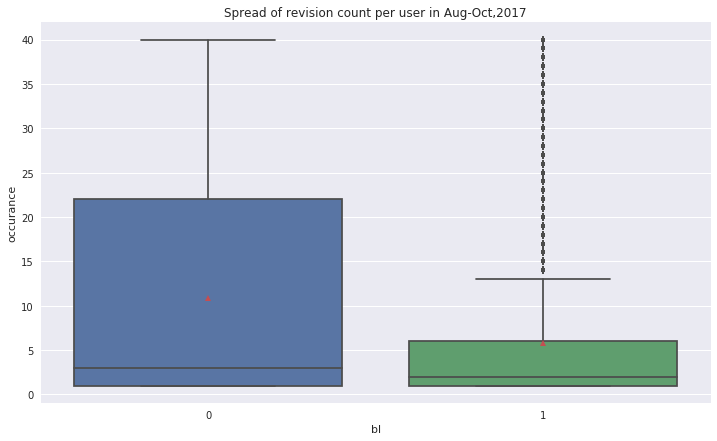

In [9]:
plt1 = pd.DataFrame(dbm.groupby(['username','bl'])['occurance'].agg(lambda x: max(x)))
plt1.reset_index(inplace=True)
print(plt1.groupby('bl')['occurance'].agg({'mean':np.average,'max':max}))
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user in Aug-Oct,2017')

In [10]:
dbm_cnt = dbm.groupby(['username','bl'])['occurance'].agg({'size1':np.size})
dbm_cnt.reset_index(inplace=True)
print(np.percentile(dbm_cnt[dbm_cnt['bl']==1].size1,[80, 25]))
np.percentile(dbm_cnt[dbm_cnt['bl']==0].size1,[80, 25])
#iqr = np.subtract(*np.percentile(x, [75, 25]))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


[8. 1.]


array([24.,  1.])

#### Spread of Active Days - Non Blocked users

(array([2635., 2200., 2323., 2261., 1998., 1805., 1772., 1704., 1574.,
        1615., 1545., 1656., 1621., 1362., 1343., 1444., 1412., 1504.,
        1801., 1642., 1588., 1492., 1444., 1602., 1501., 1538., 1515.,
        1409., 3046.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

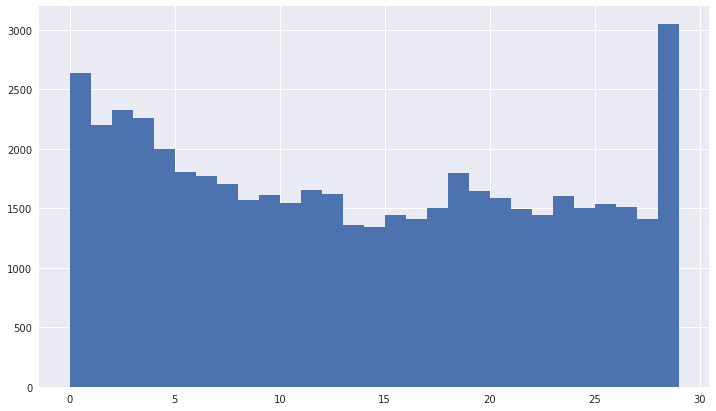

In [11]:
dbm['doi'] = (dbm.bl_date - dbm.revision_date)/7
dbm_b = dbm[dbm['bl']==0]
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_b.doi.dt.days,bins=np.arange(0,30,1))

#### Spread of Active Days - Blocked users

(array([43253.,  5905.,  3359.,  2723.,  1759.,  1577.,  1366.,  1166.,
          960.,   793.,   670.,   744.,   705.,   546.,   595.,   516.,
          449.,   523.,   397.,   412.,   345.,   423.,   271.,   355.,
          265.,   237.,   250.,   331.,   553.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <a list of 29 Patch objects>)

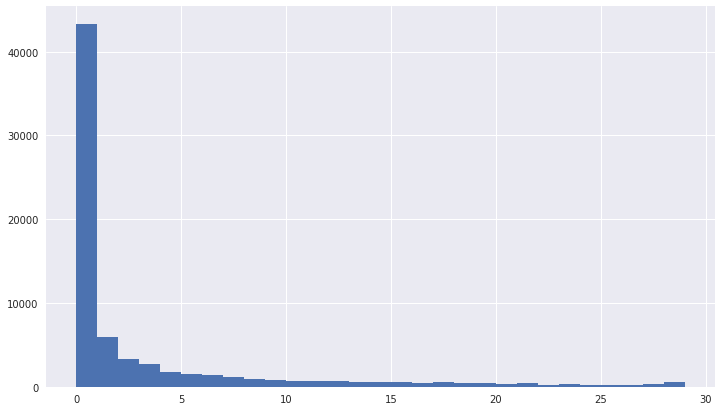

In [12]:
dbm_nb = dbm[dbm['bl']==1]
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
plt.hist(dbm_nb.doi.dt.days,bins=np.arange(0,30,1))

In [13]:
#Filtering data for top-5 comments or comments within one week each
dbm['valid_dt'] = 1
print(len(dbm))
dbm.loc[((dbm.bl==1)&(dbm.doi>'7 days')),'valid_dt']=0
dbm = dbm.loc[(dbm.valid_dt==1)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))

302680
266863
Count of Non-Blocked comment 206732 
 Count of Blocked comment 60131


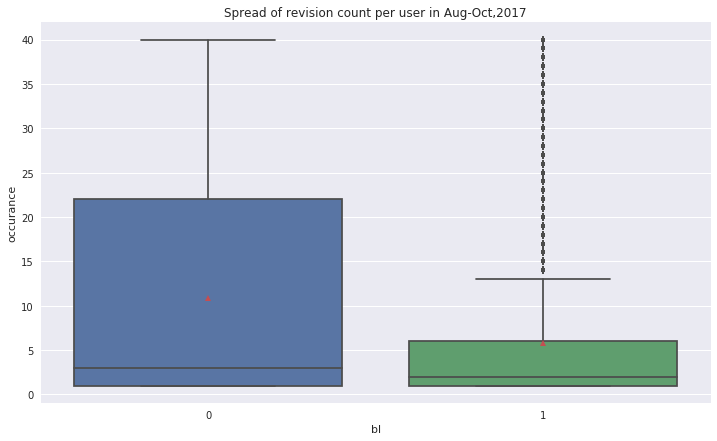

In [14]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(12,7)
h1 = sns.boxplot(x='bl',y='occurance',data=plt1,showmeans=True).set_title('Spread of revision count per user in Aug-Oct,2017')

In [15]:
dbm = dbm.loc[(dbm.occurance<=5)]
print(len(dbm))
print("Count of Non-Blocked comment",len(dbm[dbm['bl']==0]),"\n Count of Blocked comment",len(dbm[dbm['bl']==1]))
db.head()

88819
Count of Non-Blocked comment 57294 
 Count of Blocked comment 31525


,char_changes,revision_date,username,text,bl,occurance
0,+407,2015-12-15,! Bikkit !,::::In the meantime I learnt that - no matter ...,0,1
1,+156,2015-12-14,! Bikkit !,::I haved shifted this discussion to the artic...,0,2
2,+642,2015-12-14,! Bikkit !,"== Lemma ==I followed the title exactly. The ""...",0,3
3,+663,2015-09-19,! Bikkit !,"== Forwarded ""Thank you"" ==In the [https://de....",0,4
4,+370,2015-09-14,! Bikkit !,== Mathematical Tourist ==[http://mathtourist....,0,5


In [16]:
dbm.text = db.text.astype('str')

In [17]:
dbm = dbm.groupby(['username','bl']).apply(lambda x: " ".join(x.text)).to_frame().rename(columns={0:'text'})
dbm.reset_index(inplace=True)
print(dbm.bl.value_counts())
dbm.head()

0    19873
1    11368
Name: bl, dtype: int64


,username,bl,text
0,! Bikkit !,0,::::In the meantime I learnt that - no matter ...
1,!MNc99,0,== Genre ==Can I suggest we change the genre o...
2,!Silent,0,:@{{U|92.231.176.195}} Thanks! [[User:!Silent|...
3,!dea4u,0,::{{u|Flibirigit}} no i do not feel that it i...
4,!kjjk1992jk!,0,1)\tIndustry Definition\t\tThe bakery industry...


In [18]:
#dbm.to_csv('dbm_b4.txt',sep="\t")

### Feature Engineering + Data Cleaning

In [19]:
dbm.text = dbm.text.str.strip()
dbm.text = dbm.text.str.replace('(\d{1,2}:\d{1,2}, \d{1,2} [A-Za-z]* \d{1,4} \(UTC)\)'," ")
dbm.text = dbm.text.str.replace('({{[\w|\W]*?}})'," ")
dbm.text = dbm.text.str.replace('(\[\[[\w|\W]*?\]\])'," ")
dbm.text = dbm.text.str.replace('(\{\|[\w|\W]*\|\})'," ")
dbm.text = dbm.text.str.replace('(<![\w|\W]*?>)'," ")
dbm.text = dbm.text.str.replace('(<[\w|\W]*?/>)'," ")

In [20]:
dbm['clen'] = dbm.text.str.len()
dbm['numb'] = dbm.text.str.count(r'\d')/dbm['clen']
dbm['caps'] = dbm.text.str.count(r'[A-Z]')/dbm['clen']
dbm['wordlen'] = dbm.text.apply(lambda x: len(str(x).split()))
dbm['schar'] = (dbm.text.str.count(r'\W')-dbm.text.str.count(r'\W\S'))/dbm['clen']
dbm['unique_wlen_percent']=(dbm.text.apply(lambda x: len(set(str(x).split()))))/dbm['wordlen']
dbm['clen_wlen']=dbm['clen']/dbm['wordlen']
dbm.head()

,username,bl,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen
0,! Bikkit !,0,::::In the meantime I learnt that - no matter ...,1771,0.044608,0.057595,222,0.060418,0.729730,7.977477
1,!MNc99,0,== Genre ==Can I suggest we change the genre o...,696,0.000000,0.056034,112,0.094828,0.767857,6.214286
2,!Silent,0,:@ Thanks! ( ),19,0.000000,0.052632,4,0.473684,1.000000,4.750000
3,!dea4u,0,:: no i do not feel that it is not construct...,721,0.018031,0.015257,119,0.074896,0.773109,6.058824
4,!kjjk1992jk!,0,1)\tIndustry Definition\t\tThe bakery industry...,8663,0.020778,0.026088,1385,0.021471,0.443321,6.254874


In [21]:
dbm.text = dbm.text.str.replace('(={2,})'," ")
dbm.text = dbm.text.str.replace('(:{2,})'," ")
dbm.text = dbm.text.str.replace('(\s{2,})'," ")

In [22]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [23]:
#Sentiment analyzer
sentiment_val = dbm.text.apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x))

pol_values=[]
for i in sentiment_val:
    pol_val = list(i.values())
    pol_values.append(pol_val)

sent = pd.DataFrame(pol_values)
sent.rename(columns = {0:'neg',1:'neu',2:'pos',3:'compound'}, inplace=True)
sent.drop('pos', axis=1,inplace=True)
sent.head()

,neg,neu,compound
0,0.022,0.871,0.9267
1,0.072,0.817,0.6714
2,0.567,0.000,-0.2244
3,0.072,0.809,0.7783
4,0.027,0.832,0.9994


In [24]:
dbm = pd.merge(dbm,sent,how='inner',left_index=True,right_index=True)
dbm.shape
dbm[dbm.neg>0.6].head(10)

,username,bl,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
30,(TIB1024H) (Volgren),1,DICK,4,0.0,1.000000,1,0.000000,1.000000,4.000000,1.000,0.000,-0.5106
35,(TPD ACB EMD),1,F*CK ME DADDY OSHWAHHHHHH Blocked Blocked Bloc...,70,0.0,0.342857,13,0.214286,0.461538,5.384615,0.612,0.388,-0.6486
119,007Overlord,0,Stop trolling Stop trolling. Stop trolling,42,0.0,0.071429,6,0.023810,0.500000,7.000000,0.688,0.312,-0.6808
561,1.9.216.88,0,Fuck off@,9,0.0,0.111111,2,0.111111,1.000000,4.500000,0.778,0.222,-0.5423
731,101.127.207.162,0,Blocked,16,0.0,0.062500,3,0.375000,0.666667,5.333333,1.000,0.000,-0.2732
733,101.127.209.17,0,It was a mistake Typo error,32,0.0,0.062500,7,0.062500,1.000000,4.571429,0.630,0.370,-0.6249
942,103.1.70.65,0,No? ( ),11,0.0,0.090909,3,0.636364,1.000000,3.666667,1.000,0.000,-0.2960
969,103.14.62.240,0,Fuck you Fuck you,22,0.0,0.090909,5,0.090909,0.800000,4.400000,0.778,0.222,-0.7906
995,103.18.40.202,0,Pomak You are a terrorist,25,0.0,0.080000,5,0.000000,1.000000,5.000000,0.610,0.390,-0.6908
1102,103.224.49.122,0,kill yourself,16,0.0,0.000000,2,0.125000,1.000000,8.000000,0.825,0.175,-0.6908


In [25]:
dbm_sent_chk = dbm

In [26]:
#Cleaning
print(len(dbm))
dbm.text = dbm.text.str.lower()
dbm.text = dbm.text.str.replace('[^a-zA-Z]'," ")
dbm.text = dbm.text.str.replace(r'\n',' ')
dbm.text = dbm.text.str.replace(r'\s+',' ')
dbm.text = dbm.text.str.replace('([ ]{2,})',' ')
dbm = dbm[~dbm.text.str.match(r'^\s*$')]
dbm = dbm[dbm.text.apply(lambda x:len(x))>10]
print(len(dbm))
dbm.head()

31241
29113


,username,bl,text,clen,numb,caps,wordlen,schar,unique_wlen_percent,clen_wlen,neg,neu,compound
0,! Bikkit !,0,in the meantime i learnt that no matter what ...,1771,0.044608,0.057595,222,0.060418,0.729730,7.977477,0.022,0.871,0.9267
1,!MNc99,0,genre can i suggest we change the genre of th...,696,0.000000,0.056034,112,0.094828,0.767857,6.214286,0.072,0.817,0.6714
3,!dea4u,0,no i do not feel that it is not constructive ...,721,0.018031,0.015257,119,0.074896,0.773109,6.058824,0.072,0.809,0.7783
4,!kjjk1992jk!,0,industry definition the bakery industry can b...,8663,0.020778,0.026088,1385,0.021471,0.443321,6.254874,0.027,0.832,0.9994
5,!rehtom,0,darren aronofsky larger budget productions th...,1507,0.000000,0.028534,254,0.028534,0.649606,5.933071,0.068,0.821,0.8944


In [27]:
#dbm.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/dbm_after_new_corpus_all_22_02.txt',sep="\t")

In [28]:
#dbm[['username','bl']].to_csv('dbm_user_list_22_02.txt',sep="\t")

### Modeling

In [31]:
def add_feature(X, feature_to_add):
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [32]:
dbm2 = dbm.drop(['bl'],axis=1)

X_train, X_test, y_train, y_test = train_test_split(dbm2, 
                                                    dbm['bl'], 
                                                    random_state=0, test_size=0.25)
len(X_train)

21834

In [33]:
X_train.columns

Index(['username', 'text', 'clen', 'numb', 'caps', 'wordlen', 'schar',
       'unique_wlen_percent', 'clen_wlen', 'neg', 'neu', 'compound'],
      dtype='object')

#### Word n-gram model

In [34]:
vect = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(1,2),max_features=1500).fit(X_train['text'])
X_train_word = vect.transform(X_train['text'])
X_test_word = vect.transform(X_test['text'])

#### Character n-gram model

In [35]:
vect_c = TfidfVectorizer(min_df=0.005,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,6),analyzer='char',max_features=5000).fit(X_train['text'])
X_train_char = vect_c.transform(X_train['text'])
X_test_char = vect_c.transform(X_test['text'])

In [36]:
print(X_train_word.shape)
print(X_test_word.shape)

X_train_comb = hstack([X_train_word,X_train_char])
X_test_comb = hstack([X_test_word,X_test_char])

print(X_train_comb.shape)

(21834, 1500)
(7279, 1500)
(21834, 6500)


#### Char + word n-gram + sentiment

In [44]:
print(X_train_comb.shape)
for i in X_train.columns:
    if i != 'text' and i != 'username':
        X_train_comb = add_feature(X_train_comb,X_train[i])
print(X_train_comb.shape)

print(X_test_comb.shape)
for i in X_test.columns:
    if i != 'text' and i != 'username':
        X_test_comb = add_feature(X_test_comb,X_test[i])
print(X_test_comb.shape)        

(21834, 6500)
(21834, 6510)
(7279, 6500)
(7279, 6510)


#### Username based features

In [46]:
vect_c1 = TfidfVectorizer(min_df=0.01,lowercase=True,stop_words='english',norm='l1',ngram_range=(2,5),analyzer='char',max_features=200).fit(X_train['username'])
X_train_char1 = vect_c1.transform(X_train['username'])
X_test_char1 = vect_c1.transform(X_test['username'])

In [47]:
print(X_train_comb.shape)

X_train_comb1 = hstack([X_train_comb,X_train_char1])
X_test_comb1 = hstack([X_test_comb,X_test_char1])

print(X_train_comb1.shape)
X_test_comb1.shape

(21834, 6510)
(21834, 6710)


(7279, 6710)

#### Latent Dirichlet Allocation

In [48]:
lda = LatentDirichletAllocation(n_components=20, max_iter=20,learning_method='online', random_state=0)
#Online faster
lda.fit(X_train_word)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_components=20, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [49]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = f"Topic #{topic_idx}: "
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [50]:
tf_feature_names = vect.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words=10)

Topic #0: short article protect information consider kind forward access im starting
Topic #1: help sock know don ip jpg revert didn don know undo
Topic #2: redirect look non text human readers song create old character
Topic #3: small com yes span class font www http comment comment added
Topic #4: block sorry text fucking div stop px style ok em
Topic #5: super won mind blocked heart indian set days england happen
Topic #6: unblock page contested deletion contested deletion page deletion promotional reason talk welcome
Topic #7: forward access starting total groups style background lot good reasons weeks organization
Topic #8: thank nowiki br deleted add nomination nowiki nowiki speedy speedy deletion page
Topic #9: hey like man ban want id good non coming people
Topic #10: did edits thanks wikipedia warning wikipedia did mistake sup vandalism message
Topic #11: article page wikipedia just like thanks edit don know com
Topic #12: stupid dont religion okay piece interesting dear chris

In [52]:
tr_topics = lda.transform(X_train_word)
tt_topics = lda.transform(X_test_word)
tr1 = pd.DataFrame(tr_topics)
tr1.mean(axis=0)

0     0.025710
1     0.027661
2     0.026260
3     0.032762
4     0.035576
5     0.026118
6     0.034620
7     0.025638
8     0.031944
9     0.027436
10    0.048016
11    0.424731
12    0.026401
13    0.026146
14    0.027700
15    0.027781
16    0.027890
17    0.042657
18    0.028712
19    0.026242
dtype: float64

In [53]:
y_train1n = pd.DataFrame(y_train)
y_train1n.reset_index(inplace=True)
y_train1n.drop(columns = ['index'],inplace=True)
y_train1n.head()

,bl
0,0
1,1
2,0
3,1
4,0


In [54]:
xt = pd.DataFrame(X_train_comb1.todense())
print(xt.shape)
print(y_train1n.shape)
xt_c = pd.concat([xt,y_train1n],axis=1)
print(xt_c.shape)

(21834, 6710)
(21834, 1)
(21834, 6711)


In [55]:
print(X_train_comb1.shape)

X_train_comb2 = hstack([X_train_comb1,tr_topics])
X_test_comb2 = hstack([X_test_comb1,tt_topics])

print(X_train_comb2.shape)
X_test_comb2.shape

(21834, 6710)
(21834, 6730)


(7279, 6730)

#### Using XGBoost Classifier

In [58]:
xgb = XGBClassifier(n_jobs=-1, n_estimators=500, silent=0,max_depth=5)
xgb.fit(X_train_comb2, y_train)

[18:41:38] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:41:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:41:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[18:41:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[18:41:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[18:41:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:41:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[18:41:52] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[18:41:54] /work

[18:44:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[18:44:11] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:44:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[18:44:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[18:44:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[18:44:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:44:23] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:44:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:44:28] /work

[18:46:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:46:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:46:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:46:58] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[18:47:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:47:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:47:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:47:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[18:47:11] /work

[18:49:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:49:35] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[18:49:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[18:49:40] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:49:42] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:49:45] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[18:49:48] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[18:49:50] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=5
[18:49:52] /work

[18:52:13] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[18:52:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:52:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:52:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:52:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[18:52:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 36 extra nodes, 0 pruned nodes, max_depth=5
[18:52:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[18:52:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[18:52:32] /work

[18:54:54] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[18:54:56] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[18:54:59] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[18:55:01] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=5
[18:55:03] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[18:55:06] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[18:55:08] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[18:55:10] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[18:55:13] /work

[18:57:34] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[18:57:37] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 44 extra nodes, 0 pruned nodes, max_depth=5
[18:57:39] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[18:57:41] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[18:57:44] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[18:57:46] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[18:57:49] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=5
[18:57:51] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[18:57:53] /work

[19:00:15] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:00:18] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:00:20] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=5
[19:00:22] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra nodes, 0 pruned nodes, max_depth=5
[19:00:25] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 20 extra nodes, 0 pruned nodes, max_depth=5
[19:00:27] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 34 extra nodes, 0 pruned nodes, max_depth=5
[19:00:29] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[19:00:32] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[19:00:34] /work

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=0, subsample=1)

In [57]:
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_w_c_sent_user_lda_final_03_02.npz', X_test_comb2)
scipy.sparse.save_npz('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_w_c_sent_user_lda_final_03_02.npz', X_train_comb2)

In [59]:
predictions_xgb = xgb.predict(X_test_comb2)
auc = roc_auc_score(y_test, predictions_xgb)
auc

0.859746159144039

In [60]:
predictions2_xgb = pd.DataFrame(predictions_xgb)
predictions2_xgb.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/predictions2_xgb_0.86_03_02.txt',sep="\t")

#### Using Random Forest Classifier

In [61]:
rf = RandomForestClassifier(oob_score='True')
params = {'max_depth': [100], 'n_estimators':[500]}
gs_w = GridSearchCV(estimator=rf,scoring='accuracy',
                  param_grid=params,
                  n_jobs=-1,
                  cv=2,
                  verbose=5)

gs_w.fit(X_train_char1, y_train)

best_parameters = gs_w.best_params_  
print("best parameters are",best_parameters) 

best_result = gs_w.best_score_  
print("Best Score is",best_result)

predictions_rf_w = gs_w.best_estimator_.predict(X_test_char1)
auc = roc_auc_score(y_test, predictions_rf_w)
auc

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   43.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   43.5s finished


best parameters are {'max_depth': 100, 'n_estimators': 500}
Best Score is 0.7259320326096913


0.71172424830637

In [63]:
xt2 = pd.DataFrame(X_train_comb2.todense())
xtt2 = pd.DataFrame(X_test_comb2.todense())

In [64]:
X_test1n = X_test.reset_index()
X_test1n.drop(columns = ['index'],inplace=True)
X_test1n.head()
print(xtt2.shape)
xtt2 = pd.concat([X_test1n['username'],xtt2],axis=1)
print(xtt2.shape)
xtt2.head()

(7279, 6730)
(7279, 6731)


,username,0,1,2,3,4,5,6,7,8,...,6720,6721,6722,6723,6724,6725,6726,6727,6728,6729
0,Accesstowiki,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.194949,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
1,104.148.178.88,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
2,Fjs11,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050
3,109.246.48.119,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
4,Losthistory9,0.0,0.0,0.0,0.0,0.0,0.0,0.018841,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025


In [66]:
X_train1n = X_train.reset_index()
X_train1n.drop(columns = ['index'],inplace=True)
X_train1n.head()
print(xt2.shape)
xt2 = pd.concat([X_train1n['username'],xt2],axis=1)
print(xt2.shape)
xt2.head()

(21834, 6730)
(21834, 6731)


,username,0,1,2,3,4,5,6,7,8,...,6720,6721,6722,6723,6724,6725,6726,6727,6728,6729
0,Jimfbleak,0.0,0.0,0.0,0.0,0.0,0.008176,0.0,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
1,EVestigatorSimonSmith,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.013949,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
2,106.39.191.224,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
3,Alligator124827498426,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025
4,110.175.158.17,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.025,0.525,0.025,0.025,0.025,0.025,0.025,0.025,0.025,0.025


In [67]:
xt2.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_train_all_03_02.txt',sep="\t")
xtt2.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/X_test_all_03_02.txt',sep="\t")

In [69]:
y_train.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_train_all_03_02.txt',sep="\t")
y_test.to_csv('/home/ec2-user/SageMaker/bucket/wiki_trust/modeling/y_test_all_03_02.txt',sep="\t")